In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [2]:
# Load settings
from backend import sett, postgres
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Connect to database
db = postgres.connect('polylet')

      -- postgres_ SSH tunnel established.
NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.042 s)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("~/matplotlib.mplstyle")
except: pass

In [5]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

### Parsing

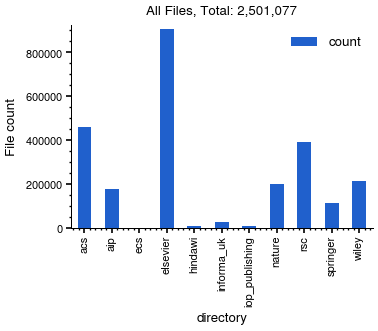

,directory,count
0,acs,457468
1,aip,177932
2,ecs,42
3,elsevier,907234
4,hindawi,6951
5,informa_uk,27900
6,iop_publishing,8007
7,nature,198487
8,rsc,392347
9,springer,111360


In [6]:
df = execute("""
             SELECT directory, count(*) FROM paper_corpus pc
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='File count', title=f"All Files, Total: {total:,}")
plt.savefig('notebooks/files_per_directory.png', dpi=600)
plt.show()
df

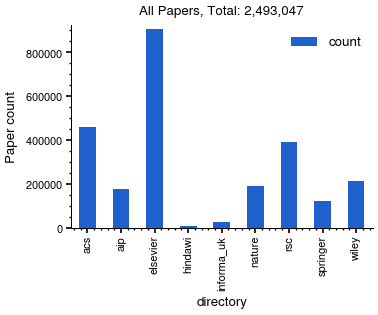

,directory,count
0,acs,457510
1,aip,177932
2,elsevier,907234
3,hindawi,6951
4,informa_uk,27898
5,nature,189039
6,rsc,392346
7,springer,120808
8,wiley,213329


In [7]:
df = execute("""
             SELECT directory, count(*) FROM papers p
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paper count', title=f"All Papers, Total: {total:,}")
plt.savefig('notebooks/papers_per_directory.png', dpi=600)
plt.show()
df

In [9]:
print("Papers in database, not in corpus:")
execute("""
    SELECT p.directory, count(*) FROM papers p
    WHERE NOT EXISTS (
        SELECT 1 FROM paper_corpus pc 
        WHERE pc.doi = p.doi
    )
    GROUP BY p.directory;
""")

Papers in database, not in corpus:


,directory,count
0,acs,22211
1,elsevier,8200
2,informa_uk,2
3,rsc,37292
4,springer,17088
5,wiley,4593


In [10]:
print("Papers in corpus, not in database:")
execute("""
    SELECT pc.directory, count(*) FROM paper_corpus pc 
    WHERE NOT EXISTS (
        SELECT 1 FROM papers p 
        WHERE p.doi = pc.doi
    )
    GROUP BY pc.directory;
""")

Papers in corpus, not in database:


,directory,count
0,acs,22169
1,ecs,42
2,elsevier,8200
3,informa_uk,4
4,iop_publishing,8007
5,nature,9448
6,rsc,37293
7,springer,7640
8,wiley,4613


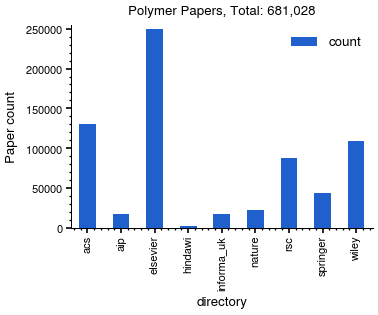

,directory,count
0,acs,130971
1,aip,17070
2,elsevier,250057
3,hindawi,2605
4,informa_uk,17396
5,nature,22208
6,rsc,87429
7,springer,44324
8,wiley,108968


In [11]:
df = execute("""
             SELECT directory, count(*) FROM papers p
             JOIN filtered_papers fp on fp.doi = p.doi
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paper count', title=f"Polymer Papers, Total: {total:,}")
plt.savefig('notebooks/polymer_papers_per_directory.png', dpi=600)
plt.show()
df

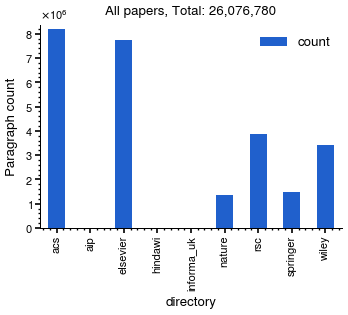

,directory,count
0,acs,8208346
1,aip,4
2,elsevier,7727368
3,hindawi,74
4,informa_uk,24
5,nature,1349847
6,rsc,3884198
7,springer,1478719
8,wiley,3428200


In [7]:
df = execute("""
        SELECT directory, count(*) FROM paper_texts pt
        GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paragraph count', title=f"All papers, Total: {total:,}")
plt.savefig('notebooks/paragraphs_per_directory.png', dpi=600)
plt.show()
df

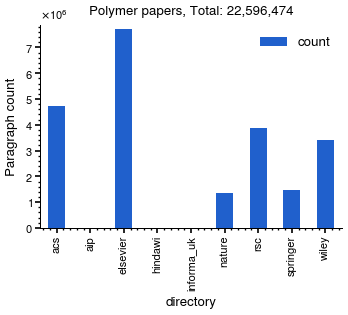

,directory,count
0,acs,4726853
1,aip,4
2,elsevier,7727367
3,hindawi,74
4,informa_uk,24
5,nature,1351035
6,rsc,3884198
7,springer,1478719
8,wiley,3428200


In [8]:
df = execute("""
        SELECT directory, count(*) FROM paper_texts pt
        -- only the polymer papers
        JOIN filtered_papers fp ON fp.doi = pt.doi 
        GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paragraph count', title=f"Polymer papers, Total: {total:,}")
plt.savefig('notebooks/poly_paragraphs_per_directory.png', dpi=600)
plt.show()
df

### Filtering

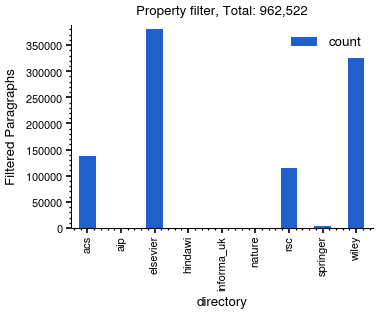

,directory,count
0,acs,137096
1,aip,4
2,elsevier,381367
3,hindawi,5
4,informa_uk,33
5,nature,16
6,rsc,114632
7,springer,3707
8,wiley,325662


In [9]:
df = execute("""
    -- property specific ner filters
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name LIKE 'property_%'
    GROUP BY pt.directory;
""")
total = df['count'].sum()

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs',
       title = f'Property filter, Total: {total:,}')
plt.savefig('notebooks/property_filtered_para_per_directory.png', dpi=600)
plt.show()
df

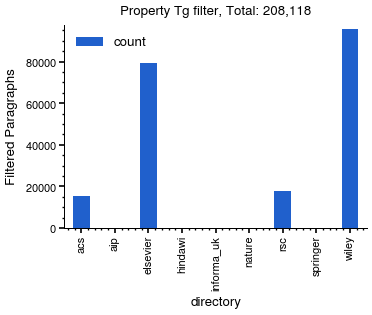

,directory,count
0,acs,15156
1,aip,2
2,elsevier,79207
3,hindawi,2
4,informa_uk,15
5,nature,10
6,rsc,17842
7,springer,53
8,wiley,95831


In [21]:
df = execute("""
    -- property specific ner filters
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name = 'property_tg'
    GROUP BY pt.directory;
""")
total = df['count'].sum()

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs',
       title = f'Property Tg filter, Total: {total:,}')
plt.savefig('notebooks/tg_filtered_para_per_directory.png', dpi=600)
plt.show()
df

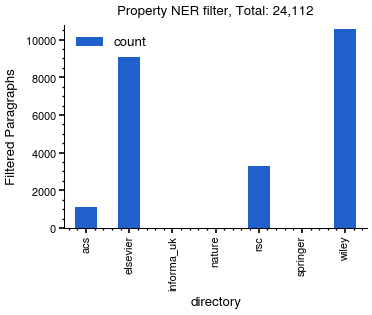

,directory,count
0,acs,1098
1,elsevier,9096
2,informa_uk,6
3,nature,2
4,rsc,3313
5,springer,15
6,wiley,10582


In [18]:
df = execute("""
    -- property specific ner filters
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name LIKE 'ner_td'
    AND fp.filter_name != 'ner_filter'
    GROUP BY pt.directory;
""")
total = df['count'].sum()

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs',
       title = f'Property NER filter, Total: {total:,}')
plt.savefig('notebooks/property_ner_filtered_para_per_directory.png', dpi=600)
plt.show()
df

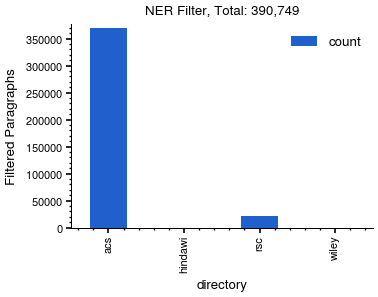

,directory,count
0,acs,369040
1,hindawi,3
2,rsc,21704
3,wiley,2


In [14]:
df = execute("""
    -- general ner filter
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name = 'ner_filter'
    GROUP BY pt.directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs', title = f'NER Filter, Total: {total:,}')
plt.savefig('notebooks/ner_filtered_para_per_directory.png', dpi=600)
plt.show()
df

### Extracted Data

In [10]:
# Materials extracted.
execute("select count(*) from extracted_materials")

,count
0,621936


In [11]:
# Properties extracted.
execute("select count(*) from extracted_properties")

,count
0,1275178


In [12]:
def extract_properties(property : str):
    df = execute("""
        SELECT pt.doi, em.entity_name AS material, ep.numeric_value, ep.unit
        FROM extracted_properties ep
        -- get material name and class
        JOIN extracted_materials em ON em.id = ep.material_id
        -- get doi
        JOIN paper_texts pt ON pt.id = em.para_id
        -- filter with property coreferents
        WHERE ep.entity_name IN (
            SELECT UNNEST(pm.other_names) FROM property_metadata pm
            WHERE pm.name = :prop_name
        )
        -- value should be within range
        AND ep.numeric_value >= (
            SELECT lower_limit FROM property_metadata
            WHERE name = :prop_name
        )
        AND ep.numeric_value <= (
            SELECT upper_limit FROM property_metadata
            WHERE name = :prop_name
        )
        -- select only polymers
        AND em.material_class LIKE 'POLYMER%';
    """, prop_name=property)
    return df

In [13]:
def unit_counts(df):
    return df.groupby('unit').nunique().numeric_value.sort_values(ascending=False)

In [14]:
def plot_histogram(df, name):
    # Most common unit
    unit = df.groupby('unit').nunique().numeric_value.sort_values(ascending=False).index[0]
    avg = df.numeric_value.mean()
    stdev = df.numeric_value.std()

    fig, ax = plt.subplots()
    df.hist('numeric_value', bins=20, label=f'Total: {df.shape[0]:,}', ax=ax)
    ax.legend()
    ax.set(xlabel=f'{name} ({unit})', ylabel='count',
           title=f'Extracted {name} data\nMean = {avg:0.2f}, St. dev. = {stdev:0.2f}')
    plt.savefig(f'notebooks/hist.{name.replace("/", "_")}.png', dpi=300)
    plt.show()

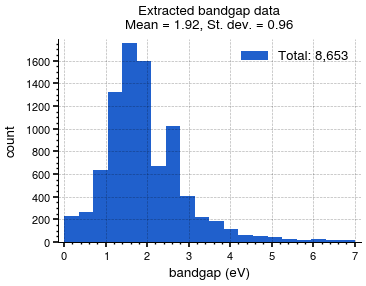

,doi,material,numeric_value,unit
0,10.1021/jacs.5b02651,MAPbI_{3},1.570,eV
1,10.1021/acs.jpcc.7b08928,IMI)­SnI_{4},1.340,eV
2,10.1021/acs.jpcc.7b08928,IMI)­SnI_{4},1.675,eV
3,10.1021/jp201019c,BDOPV-TT,2.650,eV
4,10.1021/jp201019c,BDOPV-BDT,2.650,eV
...,...,...,...,...
8648,10.1021/acsami.9b20294,polyamides,0.750,eV
8649,10.1021/jp503030b,Figure_{2} -1H,0.750,eV
8650,10.1021/acsami.0c15912,GaN,3.420,eV
8651,10.1021/acsami.0c15912,ScAlN,3.500,eV


In [15]:
df = extract_properties('bandgap')
plot_histogram(df, 'bandgap')
df

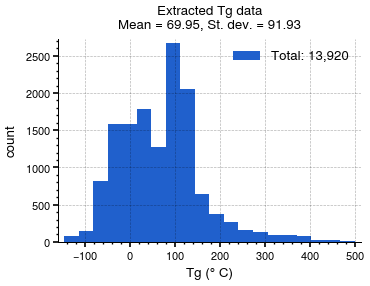

,doi,material,numeric_value,unit
0,10.1021/la060580z,hPB63,-45.0,° C
1,10.1021/la060580z,hPB63,-30.0,° C
2,10.1021/ma0201025,polystyrene,68.0,° C
3,10.1039/c7py01161j,PPhA,50.0,° C
4,10.1039/c5py00992h,PySQ,167.0,° C
...,...,...,...,...
13915,10.1021/acsapm.0c01335,ESOA,10.5,° C
13916,10.1021/acsapm.0c01335,DBEDT,10.5,° C
13917,10.1021/acsapm.0c01335,ESOA-DBEDT,10.5,° C
13918,10.1021/acsapm.0c01335,ESOA-HDT,10.5,° C


In [16]:
df = extract_properties('glass transition temperature')
plot_histogram(df, 'Tg')
df

In [11]:
# Make histograms for all properties.
props = execute("select * from property_metadata")
# for prop in props.name:
#     df = extract_properties(prop)
#     if df is not None:
#         plot_histogram(df, prop)

In [31]:
postgres.disconnect()